# **🤖 Churn - Prediction - Model Training**

En este notebook entrenamos diversos modelos de **Machine Learning** con el objetivo de predecir la **pérdida de clientes** *(churn)*. Evaluamos el rendimiento de los modelos base utilizando métricas clave, optimizamos los **hiperparámetros** de los modelos. Finalmente analizamos los resultados del mejor modelo, incluyendo la optimización del **umbral de decisión**.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Model Training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, classification_report
)

sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

## 🗂️​ Carga de datos procesados

En esta sección cargamos los dataset procesados en el Notebook *Preprocessing*. 

- `X_train`, `X_test`: Características escaladas y codificadas
- `y_train`, `y_test`: Variable objetivo 

In [6]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

## ⚙️​ Entrenamiento de modelos base

En esta sección entrenaremos tres modelos utilizando sus **hiperparámetros por defecto**. Estos modelos nos servirán como referencia inicial antes de realizar la optimización de hiperparámetros.

**Modelos a entrenar**:

1. Logistic Regression
2. XGBoost
3. Random Forest

In [7]:
from sklearn.model_selection import cross_validate

# --- Modelos ---
models = {
    'Logistic Regression': LogisticRegression(),
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier()
}

# --- Métricas ---
scoring = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1 Score': 'f1',
    'ROC-AUC': 'roc_auc'
}

# Lista para almacenar resultados
results = []

for name, model in models.items():
    sc = cross_validate(
        model,
        X_train, y_train,
        cv=5,
        scoring=scoring
    )
    # Crear diccionario con métricas
    mean_scores = {metric: sc[f'test_{metric}'].mean() for metric in scoring}
    mean_scores['Model'] = name
    results.append(mean_scores)

results_df = pd.DataFrame(results, columns=['Model'] + list(scoring.keys()))
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.802311,0.653923,0.546488,0.595169,0.845934
1,XGBoost,0.783111,0.609339,0.516388,0.558664,0.826067
2,Random Forest,0.786667,0.626446,0.488294,0.548721,0.826523


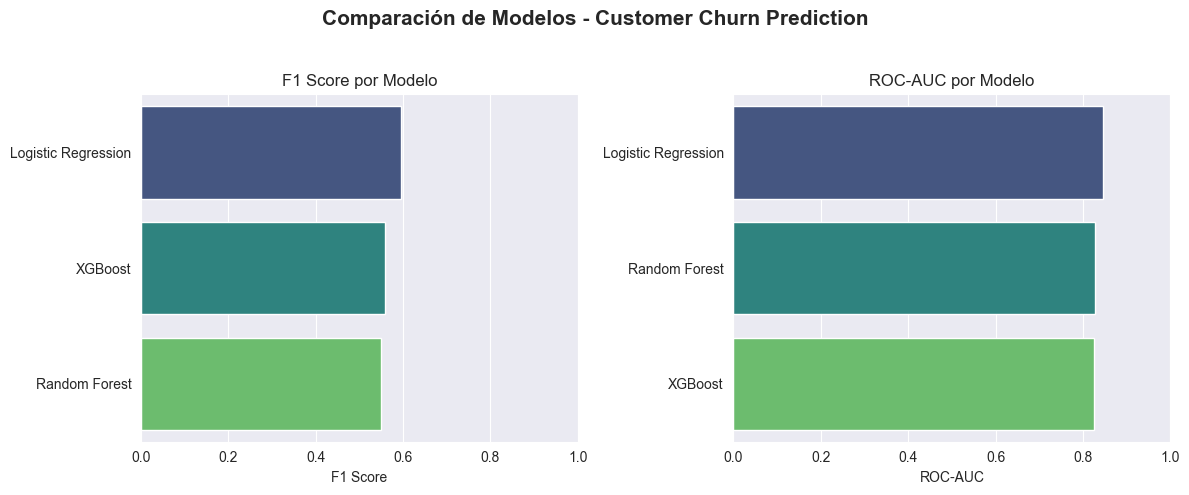

In [8]:
plt.figure(figsize=(12, 5))
metrics_to_plot = ["F1 Score", "ROC-AUC"]

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(1, 2, i)
    sorted_models = results_df.sort_values(metric, ascending=False)["Model"]
    sns.barplot(
        data=results_df,
        y="Model",
        x=metric,
        palette="viridis",
        order=sorted_models
    )
    plt.title(f"{metric} por Modelo", fontsize=12)
    plt.xlabel(metric)
    plt.ylabel("")
    plt.xlim(0, 1)

plt.suptitle("Comparación de Modelos - Customer Churn Prediction", fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 🔧​ Optimización de hiperparámetros

En esta sección optimizamos los **hiperparámetros** de nuestros modelos para mejorar su capacidad de predicción del *churn*. Utilizamos *GridSearchCV* con **validación cruzada estratificada**, lo que nos permite evaluar diferentes combinaciones de parámetors y seleccinar aquellas que maximizan las métrica **ROC-AUC**

In [9]:
# --- Cross-validation y Grid Search ---
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Definimos los modelos y sus hiperparámetros
param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],      
    'subsample': [0.8, 1.0],            
    'colsample_bytree': [0.8, 1.0],     
    'scale_pos_weight': [1, 3, 5]       
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],                    
    'min_samples_leaf': [1, 2, 4],                      
    'max_features': ['sqrt', 'log2'],                   
    'class_weight': ['balanced', 'balanced_subsample']  
}

# Configuramos la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Logistic Regression ---
log_model = LogisticRegression(max_iter=1000, random_state=42)
grid_log = GridSearchCV(log_model, param_grid_log, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_log.fit(X_train, y_train)
print("Best Logistic Regression Params:", grid_log.best_params_)
print("Best Logistic Regression ROC-AUC:", grid_log.best_score_)

# --- XGBoost ---
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best XGBoost ROC-AUC:", grid_xgb.best_score_)

# --- Random Forest ---
rf_model = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
print("Best Random Forest Params:", grid_rf.best_params_)
print("Best Random Forest ROC-AUC:", grid_rf.best_score_)
print()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic Regression Params: {'C': 10, 'class_weight': None, 'solver': 'saga'}
Best Logistic Regression ROC-AUC: 0.8462947516742652
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'scale_pos_weight': 5, 'subsample': 0.8}
Best XGBoost ROC-AUC: 0.8504980281325161
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Random Forest Params: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest ROC-AUC: 0.8483978070566133



Tras la optimización de los hiperparámetros, observamos una alta similitud de rendimiento entre los tres modelos. Para decidir cúal es el mejor modelo y proceder con su evaluación exhaustiva, revisaremos el **rendimiento**, **estabilidad** y **capacidad de generalización** de los tres modelos.

Además, visualizaremos las **curvas de aprendizaje** de cada modelo con el mismo objetivo, lo cual nos permitirá identificar problemas de **overfitting** o **underfitting** y seleccionar el modelo más robusto para la predicción de *churn*.

In [10]:
from sklearn.model_selection import cross_validate

# Modelos optimizados por GridSearchCV
best_models = {
    'Logistic Regression': grid_log.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_,
    'Random Forest': grid_rf.best_estimator_
}

best_results = {}

for name, model in best_models.items():

    # --- VALIDACIÓN CRUZADA ---
    # Entrena el modelo en 5 folds y evalúa su rendimiento en TRAIN y en VALIDACIÓN
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=5,                  # número de folds
        scoring='roc_auc',     # métrica usada
        return_train_score=True
    )

    # --- EXTRAEMOS LOS SCORES ---
    train_scores = cv_results['train_score']   # ROC-AUC en entrenamiento, 5 valores
    val_scores   = cv_results['test_score']    # ROC-AUC en validación, 5 valores

    # --- CALCULAMOS ESTADÍSTICAS ---
    train_mean = train_scores.mean()
    val_mean   = val_scores.mean()
    val_std    = val_scores.std()
    gap        = train_mean - val_mean         # diferencia → indica overfitting

    # Guardamos resultados
    best_results[name] = {
        'train_mean': train_mean,
        'val_mean': val_mean,
        'val_std': val_std,
        'overfitting_gap': gap
    }

    print(f"\n{name}:")
    print(f"  ROC-AUC validación: {val_mean:.4f} ± {val_std:.4f}")
    print(f"  ROC-AUC entrenamiento: {train_mean:.4f}")
    print(f"  Gap (overfitting): {gap:.4f}")



Logistic Regression:
  ROC-AUC validación: 0.8462 ± 0.0190
  ROC-AUC entrenamiento: 0.8514
  Gap (overfitting): 0.0052

XGBoost:
  ROC-AUC validación: 0.8479 ± 0.0164
  ROC-AUC entrenamiento: 0.8692
  Gap (overfitting): 0.0213

Random Forest:
  ROC-AUC validación: 0.8474 ± 0.0144
  ROC-AUC entrenamiento: 0.9195
  Gap (overfitting): 0.0721


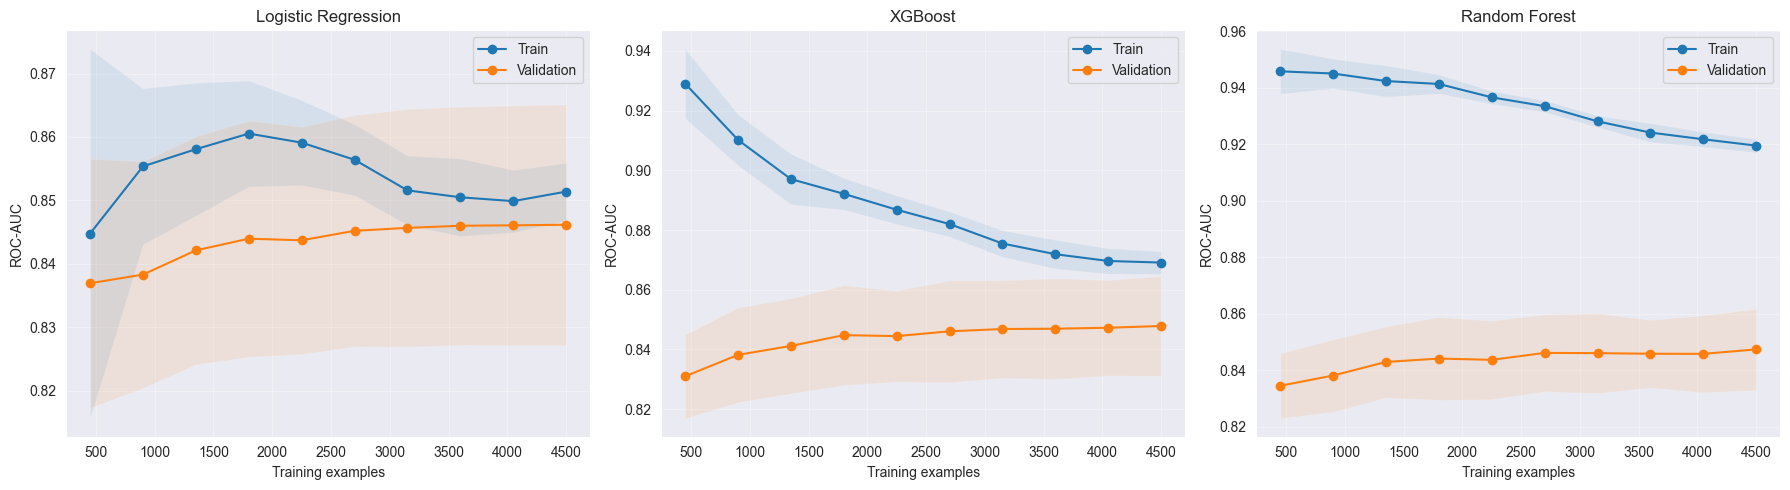

In [11]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(best_models, X_train, y_train):
    fig, axes = plt.subplots(1, len(best_models), figsize=(6 * len(best_models), 5))
    
    for ax, (name, model) in zip(axes, best_models.items()):
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train,
            cv=5,
            scoring='roc_auc',
            train_sizes=np.linspace(0.1, 1.0, 10),
            n_jobs=-1
        )
        
        # Medias y desviaciones
        train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
        val_mean, val_std = val_scores.mean(axis=1), val_scores.std(axis=1)
        
        # Curvas
        ax.plot(train_sizes, train_mean, label='Train', marker='o')
        ax.plot(train_sizes, val_mean, label='Validation', marker='o')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
        ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
        
        ax.set_xlabel('Training examples')
        ax.set_ylabel('ROC-AUC')
        ax.set_title(name)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Ejecutar
plot_learning_curves(best_models, X_train, y_train)


Pese que Logistic Regression no alcanza el mayor valor de **ROC-AUC**, lo elegimos como mejor modelo porque presenta menor **overfitting** y es más **simple** e **interpretable** que los demás modelos. Esta combinación entre robustez y simplicidad lo convierte en la mejor opción para nuestra predicción de *churn*.

## 🔎 Evaluación del modelo

En esta sección analizamos el rendimiento del modelo mediante la **matriz de confusión** y la **curva ROC**.

La **matriz de confusión** nos permite visualizar cómo se distribuyen los aciertos y errores del modelo:

| Métrica | Descripción |
|---------|-------------|
| ✅ True Positive (TP) | Clientes correctamente identificados como *churn*. |
| ❌ False Negative (FN) | Clientes que abandonan pero el modelo no los predice (error crítico) |
| ❌ False Positive (FP) | Clientes fieles clasificados erróneamente como *churn* (error leve) |
| ✅ True Negative (TN) | Cliente correctamente identificados como no *churn* |

Dado que en el sector de telecomunicaciones la **retención de clientes tiene un menor coste que la adquisición de uno nuevo** nuestro **objetivo principal es minimizar los *False Negatives (FN)*** y **maximizar el Recall**, incluso si esto implica un leve aumento en los *False Positives (FP)*.

La **curva ROC** permite visualizar el **rendimiento** de un modelo de clasificación en todos los umbrales de decisión posibles.

In [12]:
# --- Predicciones ---
y_pred = grid_log.best_estimator_.predict(X_test)

# --- Matriz de confusión --- 
cm = confusion_matrix(y_test, y_pred)

# --- Reporte de clasificación ---
report = classification_report(y_test, y_pred)

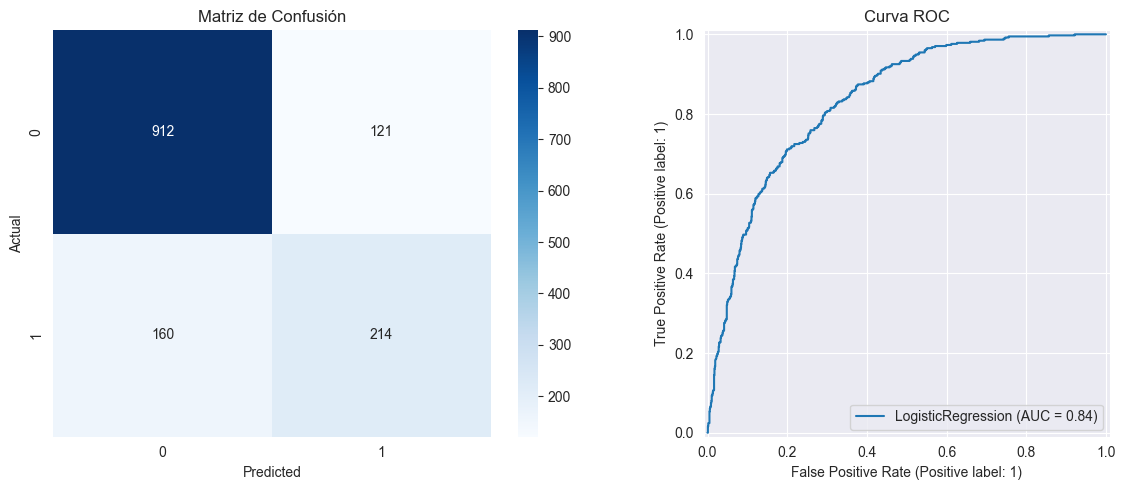

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Heatmap Matriz de confusión ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Matriz de Confusión')

# --- Curva ROC ---
RocCurveDisplay.from_estimator(grid_log.best_estimator_, X_test, y_test, ax=axes[1])
axes[1].set_title('Curva ROC')

plt.tight_layout()
plt.show()

In [14]:
print(report)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1033
           1       0.64      0.57      0.60       374

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.74      1407
weighted avg       0.79      0.80      0.80      1407



## ♻️ Umbral de decisión (Threshold Tuning) 

Los modelos de clasificación (como Logistic Regression) predicen una probabilidad de pertenencia a la clase *churn*, no una etiqueta directa 0/1. Por defecto, se usa un umbral de 0.5 para decidir si un cliente es *churn* (1) o *no churn* (0).

Sin embargo, este umbral puede ajustarse según el objetivo estratégico.

En nuestro caso, nos interesa maximizar recall (evitar falsos negativos) lo que equivale a bajar el umbral. A continuación, evaluamos las métricas **Recall**, **Precision** y **F1-score** para distintos umbrales, lo que nos permite seleccionar el **punto óptimo** de decisión.

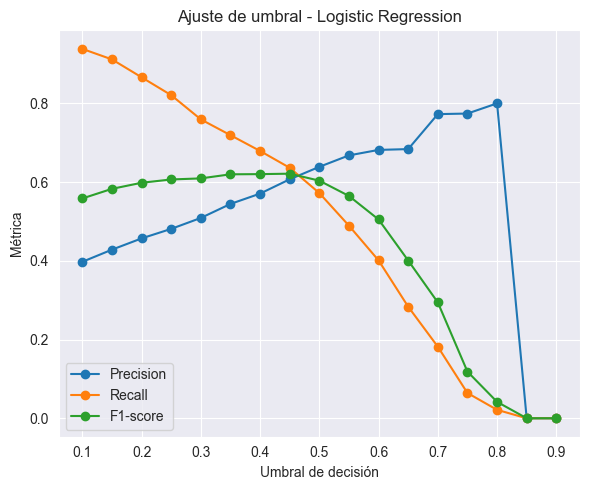

In [15]:
# --- Probablidades clase positiva ---
y_prob = grid_log.best_estimator_.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
metrics_log = {'threshold': [], 'precision': [], 'recall': [], 'f1': []}

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    metrics_log['threshold'].append(t)
    metrics_log['precision'].append(precision_score(y_test, y_pred_t))
    metrics_log['recall'].append(recall_score(y_test, y_pred_t))
    metrics_log['f1'].append(f1_score(y_test, y_pred_t))

# Graficar resultados para Logistic Regression
plt.figure(figsize=(6, 5))

plt.plot(metrics_log['threshold'], metrics_log['precision'], label='Precision', marker='o')
plt.plot(metrics_log['threshold'], metrics_log['recall'], label='Recall', marker='o')
plt.plot(metrics_log['threshold'], metrics_log['f1'], label='F1-score', marker='o')

plt.xlabel('Umbral de decisión')
plt.ylabel('Métrica')
plt.title('Ajuste de umbral - Logistic Regression')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Seleccionamos el threshold que maximiza el F1-score | Asegurando un mejor Recall sin sacrificar demasiado Precision
best_idx = np.argmax(metrics_log['f1'])
best_threshold = metrics_log['threshold'][best_idx]
print(f"Mejor threshold (F1-score): {best_threshold:.2f}")

# Predicciones finales con el threshold óptimo
final_preds = (y_prob >= best_threshold).astype(int)

cm = confusion_matrix(y_test, final_preds)
print("Matriz de confusión:\n", cm)
print("\nReporte de clasificación:\n", classification_report(y_test, final_preds, digits=3))

Mejor threshold (F1-score): 0.45
Matriz de confusión:
 [[879 154]
 [136 238]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0      0.866     0.851     0.858      1033
           1      0.607     0.636     0.621       374

    accuracy                          0.794      1407
   macro avg      0.737     0.744     0.740      1407
weighted avg      0.797     0.794     0.795      1407



Podemos ver una reducción en el numéro de *False Negatives*, que es precisamente nuestro objetivo.

## 📄​ Importancia de las características (Feature Importance)

En esta sección analizaremos la importancia de las características para nuestro modelo. Esto nos ayudará a enternder qué variables tienen mayor impacto en la predicción de *churn*, sirviendo de guía para futuras estrategias de retención de clientes.

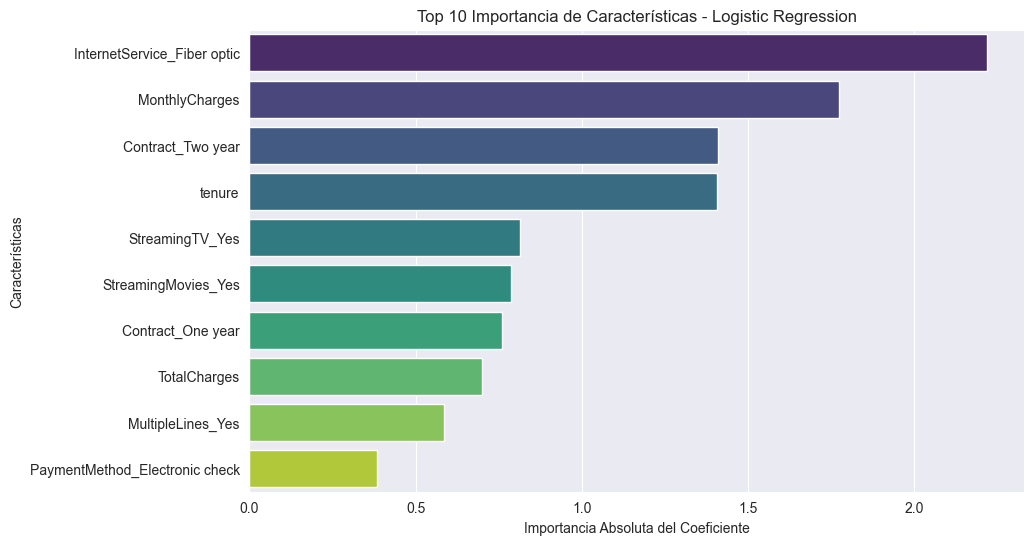

In [17]:
# Importancia de características para Logistic Regression

coef_log = grid_log.best_estimator_.coef_[0]
features_log = X_train.columns
importance_log = pd.DataFrame({'Feature': features_log, 'Importance': np.abs(coef_log)})
importance_log = importance_log.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_log.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Importancia de Características - Logistic Regression')
plt.xlabel('Importancia Absoluta del Coeficiente')
plt.ylabel('Características')
plt.show()

## 📌 Conclusiones

- **Logistic Regression** se perfila como el módelo óptimo para predecir churn.
- El ajuste del umbral de decisión permite adaptar el comportamiento del modelo a las necesidades específicas del negocio.
- La importancia de características revelan insights significativos acerca de los factores que influyen más en la pérdida de clientes.
- **Futuros pasos**: será recomendable implementar un sistema de monitoreo que permita evaluar continuamente el rendimiento del modelo y, además, incorporar nuevos datos para su actualización y mejora. Así como la exploración de nuevos modelos.
